In [47]:
import os


import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import torch
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl 

GPUS = int(torch.cuda.is_available())
torch.cuda.empty_cache() 
if GPUS:
    t = torch.cuda.get_device_properties(0).total_memory
    r = torch.cuda.memory_reserved(0)
    a = torch.cuda.memory_allocated(0)
    f = r-a  # free inside reserved

    print("torch.cuda.get_device_properties(0).total_memory %fGB"%(t/1024/1024/1024))
    print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
    print("torch.cuda.memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
    print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))
    print("Free (res - alloc) %fGB"%(f/1024/1024/1024))

torch.cuda.get_device_properties(0).total_memory 15.781738GB
torch.cuda.memory_allocated: 0.008954GB
torch.cuda.memory_reserved: 0.041016GB
torch.cuda.max_memory_reserved: 1.978516GB
Free (res - alloc) 0.032062GB


In [48]:
val_ratio = 0.2
batch_size = 64


seed = 0
standardise_axes = (0, 1)  # per sample standardisation

num_workers = 6
pin_memory = True

### TESS DATA

In [49]:
if GPUS:
    path = "/state/partition1/mmorvan/data/TESS/lightcurves/0001"
else:
    path = "/Users/mario/data/TESS/lightcurves/0027"

train_path = os.path.join(path, 'processed_train')
test_path = os.path.join(path, 'processed_test')

In [50]:
# # split generation
# import os
# from datasets import TessDataset

# test_ratio = 0.2
    
# dataset = TessDataset(path, 
#                       processed=True, 
#                       save=False
#                       )

# #dataset.n_dim = 1
# # TRAIN/VAL SPLIT
# test_size = int(test_ratio * len(dataset))
# train_size = len(dataset) - test_size
# print(train_size, test_size)
# train_dataset, test_dataset = random_split(dataset, 
#                                           (train_size, test_size),
#                                            generator=torch.Generator().manual_seed(seed))

# for idx in train_dataset.indices:
#     dataset.save_item(idx, train_path)
# for idx in test_dataset.indices:
#     dataset.save_item(idx, test_path)
# #train_dataset.indices

# %%bash
# ls "/state/partition1/mmorvan/data/TESS/lightcurves/0001/processed_test" 

In [51]:
from datasets import TessDataset

test_dataset = TessDataset(test_path, load_processed=True)
train_dataset = TessDataset(train_path, load_processed=True)
len(test_dataset), len(train_dataset)

(3177, 12712)

In [52]:

from datasets import TessDataset

from transforms import  Compose,StandardScaler, AddGaussianNoise, Mask, FillNans, RandomCrop, DownSample


    
transform_both = Compose([RandomCrop(800),
                          DownSample(2),
                          StandardScaler(dim=0),
                         ])

transform = Compose([
                     Mask(0.3, block_len=None, value=None),
                    ])
if GPUS:
    path = "/state/partition1/mmorvan/data/TESS/lightcurves/0001"
else:
    path = "/Users/mario/data/TESS/lightcurves/0027"

dataset = TessDataset(train_path, 
                      load_processed=True, 
                      #max_samples=1000,
                      transform=transform,
                      transform_both=transform_both,
                      )
test_dataset = TessDataset(test_path, 
                           load_processed=True, 
                           transform_both=transform_both,
                          )


#dataset.n_dim = 1
# TRAIN/VAL SPLIT
val_size = int(val_ratio * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, 
                                          (train_size, val_size),
                                           generator=torch.Generator().manual_seed(seed))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                          num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                          num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                          num_workers=num_workers, pin_memory=pin_memory)


In [141]:
test_dataset = TessDataset(test_path, 
                           load_processed=True, 
                           transform_both=transform_both,
                          )

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                          num_workers=num_workers, pin_memory=pin_memory)


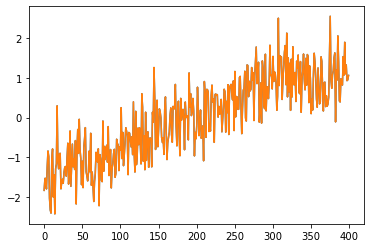

In [53]:
x, y, m, meta = dataset[0]

plt.plot(x)
plt.plot(y)

## Noise Study

/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:174: UserWarning: zero norms
  warnings.warn('zero norms')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called wi

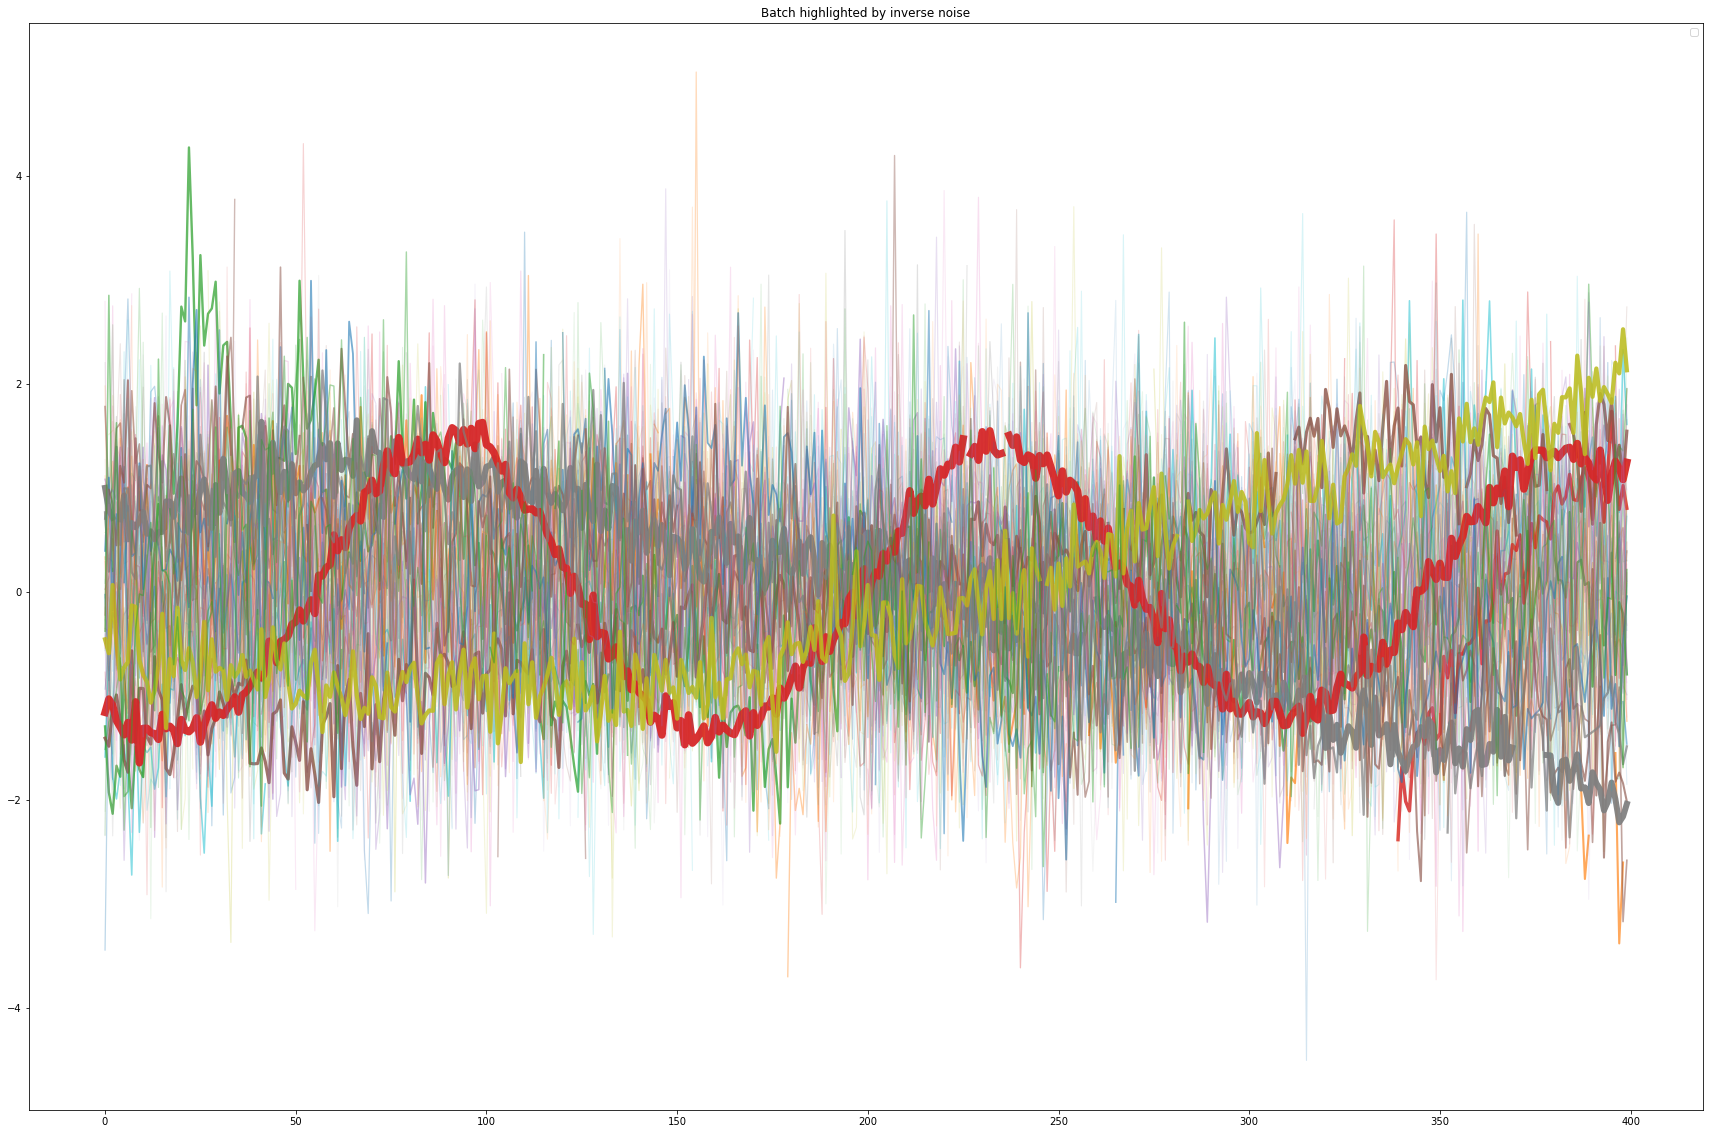

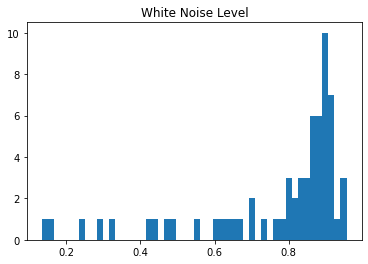

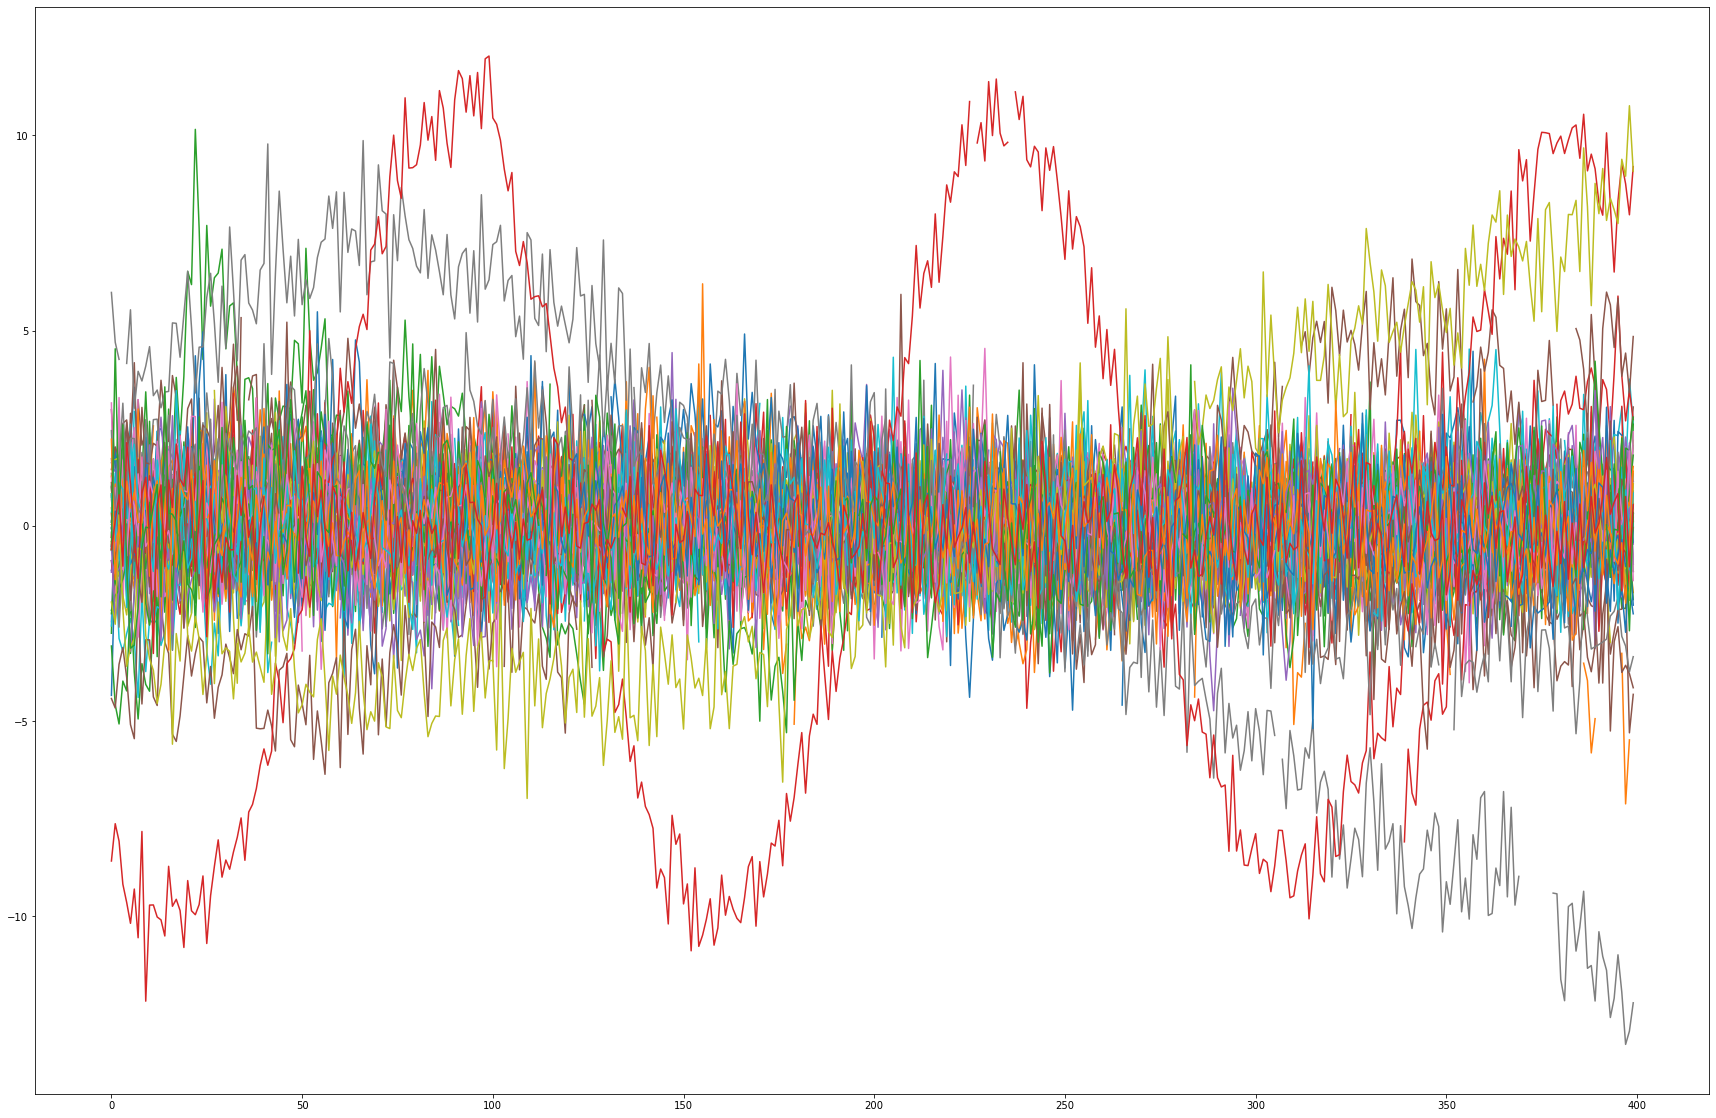

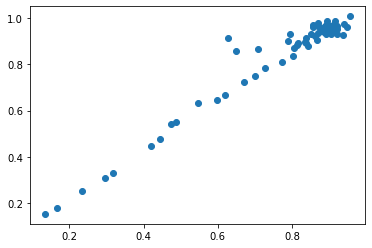

In [286]:
from utils import nanstd
X,_,_,_ = next(iter(train_loader))
B, L, D = X.shape


window = 10
n_windows = L // window
X.view(B, n_windows, window).shape

noise = nanstd(X.view(B, n_windows, window), -1, keepdim=True).nanmedian(1, keepdim=True).values

# Samples highlighted by non-white-noise contribution to the variance
plt.figure(figsize=(30,20))
for i in range(len(X)):
    plt.plot(X[i,:,0], alpha=1-noise[i,0,0].item()**1.5, lw=1/noise[i,0,0])
plt.title('Batch highlighted by inverse noise')
plt.legend()
plt.show()

# Distribution of noise estimates
plt.hist(noise[:,0,0].numpy(), 50)
plt.title('White Noise Level')
plt.show()

# After correction
plt.figure(figsize=(30,20))
plt.plot((X / noise)[:,:,0].T)
plt.show()

# Check of better noise estimate

def rolling_std(x, width=10):
    return pd.Series(x).rolling(width, center=True, min_periods=1).std().values

better_noise = []
for i in range(len(X)):
    better_noise += [np.nanmedian(rolling_std(X[i,:,0].numpy(), width=10))]
plt.scatter(noise, better_noise)

pass

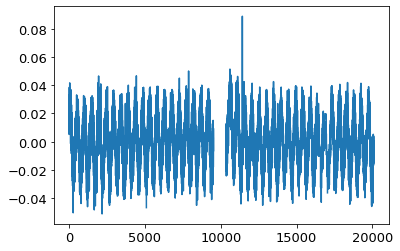

In [340]:
dataset_temp = TessDataset(train_path)


x, y, m, i = dataset_temp[np.random.randint(len(dataset_temp))]
plt.plot((x - np.nanmedian(x))/np.nanmedian(x))

### Dummy Data

In [65]:
from datasets import DummyDataset

dataset = DummyDataset(100)


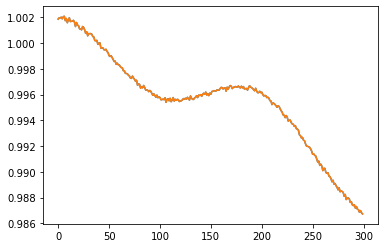

In [66]:
x, y, m, meta = dataset[0]

plt.plot(x)
plt.plot(y)

### Model

In [54]:
from models import LitImputer
torch.manual_seed(0)

In [55]:
# ### TEST RUN
# lit_model = LitImputer(1)
# trainer = pl.Trainer(max_epochs=2, gpus=GPUS)
# result = trainer.fit(lit_model, train_dataloaders=train_loader)

batch size 64


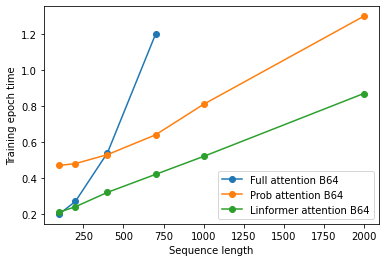

In [56]:
# # size study
list_seq_len = [100, 200,  400, 700, 1000, 2000]
# for L in list_seq_len:
#     torch.cuda.empty_cache()
#     lit_model = LitImputer(n_dim, d_model=64, dim_feedforward=128,  num_layers=3, eye=eye, lr=0.001,
#                        normal_ratio=0.2, keep_ratio=0., token_ratio=0.8, attention='linear', seq_len=L
#                       )
    
#     dataset.transform_both = Compose([RandomCrop(L),
#                                       StandardScaler(dim=0),
#                                      ])
#     train_loader = DataLoader(dataset, batch_size=64, shuffle=True) 

#     trainer = pl.Trainer(max_epochs=3, 
#                          gpus=1, profiler='simple')

#     result = trainer.fit(lit_model, 
#                          train_dataloaders=train_loader,                     
#                          )

# result_full = [0.16705 , 0.24147, 0.51497, np.nan, np.nan, np.nan] #B256
result_full = [0.2 , 0.27, 0.54, 1.2, np.nan, np.nan] #B64
# result_prob = [ 0.30687, 0.33286, 0.38871, 0.54279, 0.68638, 1.1525 ] #B256
result_prob = [0.47, 0.48, 0.53, 0.64, 0.81, 1.3] #B64

###result_lin = [0.25, 0.31, 0.46, 0.65, 0.87, 1.53] #B64
result_lin = [0.21, 0.24, 0.32, 0.42, 0.52, 0.87]
plt.plot(list_seq_len, result_full, marker='o', label='Full attention B64')#, marker='-o')
plt.plot(list_seq_len, result_prob, marker='o', label='Prob attention B64')
plt.plot(list_seq_len, result_lin, marker='o', label='Linformer attention B64')
plt.legend()
plt.xlabel('Sequence length')
plt.ylabel('Training epoch time')
print('batch size', train_loader.batch_size)

In [57]:
eye = 0
# n_dim = dataset.n_dim
n_dim = 1
torch.manual_seed(0)
lit_model = LitImputer(n_dim, d_model=64, dim_feedforward=128,  num_layers=3, eye=eye, lr=0.001,
                       normal_ratio=0.2, keep_ratio=0., token_ratio=0.8, #attention='linear', seq_len=400
                      )

In [58]:
from pytorch_lightning.loggers import NeptuneLogger
logger = NeptuneLogger(project="denoising-transformer",
                       name=str(dataset),
                       log_model_checkpoints=False,
                       tags=[
                               "large-training-set"
                        #      "Noise2Noise",
                        #      "Imputation",
                        #      "cropped-800",
                        #      "downsampled-2",
                        #      'linformer'
                             #"replaced_normal",
                             #"Crop-400", 
#                              f"patch-{patch_size}",
#                              "TPT"
                            ])

In [59]:
# from pytorch_lightning import seed_everything
# seed_everything(1)

trainer = pl.Trainer(max_epochs=500, 
                     logger=logger, 
                     gpus=GPUS,
                     check_val_every_n_epoch=1)

result = trainer.fit(lit_model, 
                     train_dataloaders=train_loader,
                     val_dataloaders=val_loader, 
                     )



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


https://app.neptune.ai/yottario/denoising-transformer/e/DEN-128
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


Set SLURM handle signals.

  | Name        | Type               | Params
---------------------------------------------------
0 | ie          | Linear             | 128   
1 | pe          | PosEmbedding       | 0     
2 | ea          | EyeAttention       | 0     
3 | encoder     | TransformerEncoder | 100 K 
4 | recons_head | Linear             | 65    
5 | criterion   | MaskedMSELoss      | 0     
6 | iqr_loss    | IQRLoss            | 0     
---------------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.403     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Training: 0it [00:00, ?it/s]

/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:174: UserWarning: zero norms
  warnings.warn('zero norms')
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.

Validating: 0it [00:00, ?it/s]

/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWa

Validating: 0it [00:00, ?it/s]

/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWa

Validating: 0it [00:00, ?it/s]

/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:174: UserWarning: zero norms
  warnings.warn('zero norms')
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:174: UserWarning: zero norms
  warnings.warn('zero norms')
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:174: UserWarning: zero norms
  warnings.warn('zero norms')
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeW

Validating: 0it [00:00, ?it/s]

/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWa

Validating: 0it [00:00, ?it/s]

/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWa

Validating: 0it [00:00, ?it/s]

/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWa

Validating: 0it [00:00, ?it/s]

/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:174: UserWarning: zero norms
  warnings.warn('zero norms')
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:174: UserWarning: zero norms
  warnings.warn('zero norms')
/home/mmorvan/deno

Validating: 0it [00:00, ?it/s]

/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWa

Validating: 0it [00:00, ?it/s]

/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:174: UserWarning: zero norms
  warnings.warn('zero norms')
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:174: UserWarning: zero norms
  warnings.warn('zero norms')
/home/mmorvan/deno

Validating: 0it [00:00, ?it/s]

/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWa

Validating: 0it [00:00, ?it/s]

/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWa

Validating: 0it [00:00, ?it/s]

/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWa

Validating: 0it [00:00, ?it/s]

/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWa

Validating: 0it [00:00, ?it/s]

/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:174: UserWarning: zero norms
  warnings.warn('zero norms')
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:174: UserWarning: zero norms
  warnings.warn('zero norms')
/home/mmorvan/deno

Validating: 0it [00:00, ?it/s]

/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:174: UserWarning: zero norms
  warnings.warn('zero norms')
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:174: UserWarning: zero norms
  warnings.warn('zero norms')
/home/mmorvan/deno

Validating: 0it [00:00, ?it/s]

/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:174: UserWarning: zero norms
  warnings.warn('zero norms')
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.

Validating: 0it [00:00, ?it/s]

/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWa

In [60]:
trainer.test(lit_model, 
             dataloaders=test_loader
                     )

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mmorvan/denoising-ts-transformer/transforms/transforms.py:165: RuntimeWarning: Mean of empty slice
  self.centers = np.nanmean(x, self.dim, keepdims=True)
/home/mmorvan/miniconda3/envs/lct/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_IQR': 1.052728295326233,
 'test_mmse': 0.8866941332817078,
 'test_rmse': 0.9414903521537781}
--------------------------------------------------------------------------------


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mmorvan/miniconda3/envs/lct/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mmorvan/miniconda3/envs/lct/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)


[{'test_mmse': 0.8866941332817078,
  'test_rmse': 0.9414903521537781,
  'test_IQR': 1.052728295326233}]

  File "/home/mmorvan/miniconda3/envs/lct/lib/python3.9/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/home/mmorvan/miniconda3/envs/lct/lib/python3.9/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])


In [12]:


# plt.figure(figsize=(13,6))
# plt.scatter(range(len(X[i])), X[i,:,j], label='input', color='blue', s=3, alpha=0.4)

# plt.plot(Y[i,:,j], label='target', color='green')

# plt.plot(pred.cpu().detach()[i,:,j], label='prediction', color='red')
# plt.legend()

In [182]:
lit_model.eval()#.cuda()
X, Y, M, I = next(iter(test_loader))
Y_pred = lit_model(X, torch.zeros_like(X, dtype=bool)).detach().cpu().numpy()


In [183]:
from utils.postprocessing import plot_pred_diagnostic



#plot_pred_diagnostic(x, y, y_pred, mask=mask, ingo=info)

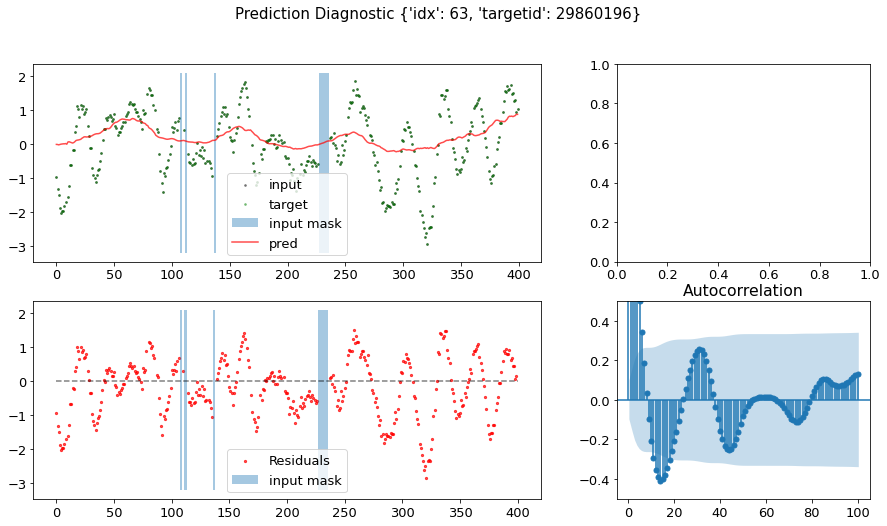

In [289]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'font.size': 13})

# i = np.random.randint(len(X))
# j = np.random.randint(n_dim)

x = X[i,:,0].detach().cpu().numpy()
y = Y[i,:,0].detach().cpu().numpy()
mask = M[i,:,0].detach().cpu().numpy()
info = {k:v[i].detach().cpu().item() for k,v in I.items()}
y_pred = Y_pred[i,:,0]



# res_m = res.copy()
# res_m[~mask] = np.nan

ratio_missing = np.isnan(y).mean()

# res_nom = res.clone()


res = y - y_pred

f, ax = plt.subplots(2, 2, figsize=(15,8), gridspec_kw={'width_ratios':[2,1]})

# PREDICTION

ax[0,0].scatter(range(len(x)), y, label='input', color='black', s=3, alpha=0.4)
if not np.isclose(x, y, equal_nan=True).all():
    ax[0,0].scatter(range(len(x)), y, label='target', color='green', s=3, alpha=0.4)
    
ymin, ymax = ax[0,0].get_ylim()
ax[0,0].fill_between(range(len(x)), [ymin]*len(x), [ymax]*len(x), where=mask, alpha=0.4, label='input mask')

#ax[0,0].plot(y, label='target', color='green', alpha=0.7)
ax[0,0].plot(y_pred, label='pred', color='red', alpha=0.7)
# ax[0,0].scatter(range(len(res)), pred_m, marker="s", color='red')
ax[0,0].legend()

# RESIDUAL 
ax[1,0].plot([0, len(res)], [0,0], linestyle='dashed', c='black', alpha=0.5)
ax[1,0].scatter(range(len(res)), res, color='red', alpha=0.7, s=5, label='Residuals')
ax[1,0].fill_between(range(len(x)), [ymin]*len(x), [ymax]*len(x), where=mask, alpha=0.4, label='input mask')
ax[1,0].legend()

# ACF
plot_acf(res, lags=100, ax=ax[1,1], missing='drop')
ax[1,1].set_ylim(-0.5, 0.5)

# # PACF
# plot_pacf(res, lags=100, ax=ax[1,1], method='ywm') #, missing='drop')
# ax[1,1].set_ylim(-0.5, 0.5)

# title
title = 'Prediction Diagnostic ' + (str(info) if info is not None else '')
f.suptitle(title, fontsize=15)

pass

In [166]:
res

array([-0.38962463,  0.39986637,  0.5764678 ,  0.7872928 , -1.9506165 ,
        0.8062025 , -0.46010855, -0.81596726, -0.39143154,  0.9869448 ,
        1.0517285 ,  0.91281754,  0.7262691 ,  0.68841857, -2.124079  ,
       -1.5152936 , -1.2105465 , -0.4220792 , -0.11005907,  0.08281472,
       -0.15197909,  0.8133959 ,  0.7273808 , -0.5023333 , -0.65115505,
       -1.1065283 , -0.5364621 , -1.4616435 , -0.2902813 ,  0.0982364 ,
       -0.42321658, -1.345854  , -0.476181  ,  0.59275573, -0.5122234 ,
       -1.9300863 ,  0.73209935, -1.640904  ,  2.2312717 ,  1.2219843 ,
       -0.04585521, -0.19882649,  0.4626236 ,  0.49867603,  0.05335055,
        0.586136  ,  0.27096125, -0.45694104, -0.2538868 , -0.08307915,
       -0.03069753, -0.94511294, -0.89075184,  0.8582355 , -0.06521562,
        1.0696546 ,  1.1784663 ,  0.9373159 , -1.5500674 ,  0.95449   ,
       -0.19750309,  1.8239589 ,  0.05259896, -1.568971  , -1.663732  ,
       -2.5497854 , -0.9941162 ,  0.13144231,  2.5816185 , -0.83

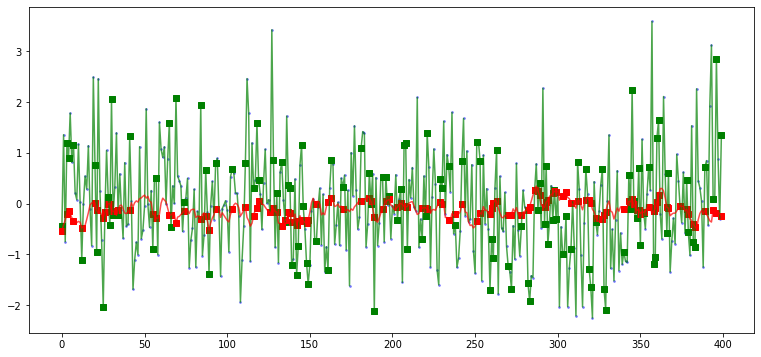

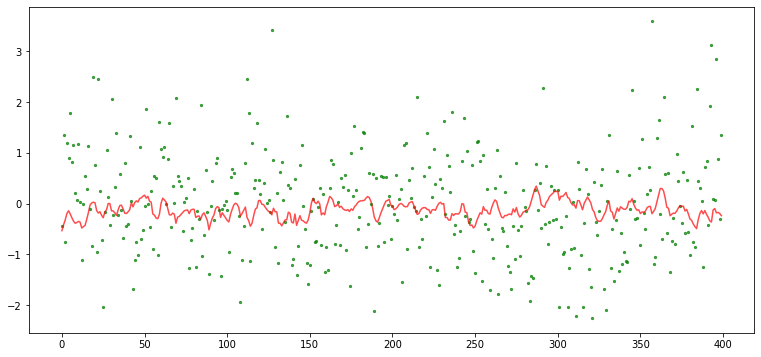

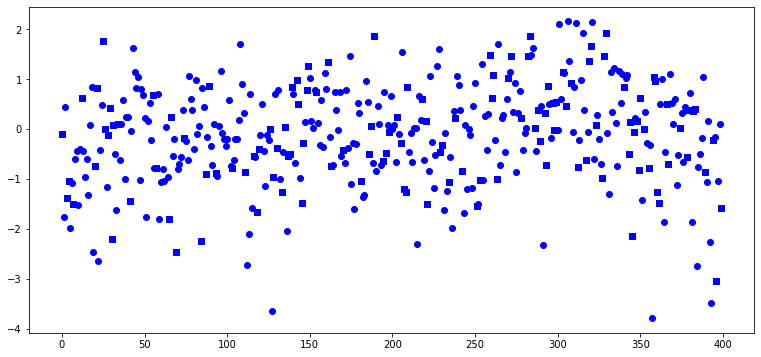

In [23]:
lit_model.eval()#.cuda()
X, Y, M, info = next(iter(val_loader))
#X = X/2

pred = lit_model(X, torch.zeros_like(X, dtype=bool)).detach()
pred2 = pred.clone()
i = np.random.randint(len(X))
j = np.random.randint(n_dim)

res = pred.cpu().detach()[i,:,j]-Y[i,:,j]
res_m = res.clone()
# res_nom = res.clone()

res_m[~M[i,:,j]] = np.nan
# res_nom[M[i,:,j]] = np.nan

target = Y[i,:,j].clone()
target_m = target.clone()
# target_nom = target.clone()
target_m[~M[i,:,j]] = np.nan
# target_nom[M[i,:,j]] = np.nan


pred = pred.cpu().detach()[i,:,j].clone()
pred_m = pred.clone()
# pred_nom = pred.clone()

pred_m[~M[i,:,j]] = np.nan
# pred_nom[M[i,:,j]] = np.nan

plt.figure(figsize=(13,6))

plt.scatter(range(len(X[i])), X[i,:,j], label='input', color='blue', s=3, alpha=0.4)

plt.plot(target, label='target', color='green', alpha=0.7)
#plt.scatter(range(len(res)), target_nom, color='green', alpha=0.7)
plt.scatter(range(len
                  (res)), target_m, marker="s", color='green')
# plt.show()
# plt.figure(figsize=(13,6))

plt.plot(pred, label='pred', color='red', alpha=0.7)
#plt.scatter(range(len(res)), pred_nom, color='red', alpha=0.7)
plt.scatter(range(len(res)), pred_m, marker="s", color='red')
plt.show()
plt.figure(figsize=(13,6))
#plt.scatter(range(len(target)),  X[i,:,j], label='target', color='blue', alpha=0.7)


plt.scatter(range(len(target)), target, label='target', color='green', alpha=0.7, s=5)
plt.plot(pred, label='pred', color='red', alpha=0.7)
plt.show()
plt.figure(figsize=(13,6))

# plt.scatter(range(len(res)), res_nom)
plt.scatter(range(len(res)), res, color='blue')
plt.scatter(range(len(res)), res_m, marker="s", color='blue')

#plt.plot(M[i,:,j])

In [29]:
pred
def median_filter(x, width=10):
    return pd.Series(x).rolling(width, center=True, min_periods=1).median().values

def mean_filter(x, width=10):
    return pd.Series(x).rolling(width, center=True, min_periods=1).mean().values


pred_mean = dict()
res_mean = dict()
res_median = dict()

pred_median = dict()
for w in (10, 25, 40, 55):
    pred_mean[w] = np.vstack([mean_filter(x[:,0], w) for x in X])
    res_mean[w] = pred_mean[w] - Y[i,:,j].detach().numpy()
    pred_median[w] = np.vstack([median_filter(x[:,0], w) for x in X])
    res_median[w] = pred_median[w] - Y[i,:,j].detach().numpy()

    # i = np.random.randint(len(Y))
    # plt.plot(X[i])
    # plt.plot(Y[i])
    # plt.plot(pred[i])

    mse_median = MaskedMSELoss()(torch.tensor(pred_median[w]), Y[:,:,0]).item()
    mse_mean = MaskedMSELoss()(torch.tensor(pred_mean[w]), Y[:,:,0]).item()
    print(f'\twindow = {w}')
    print(f'median filter : {mse_median:.4f}')
    print(f'mean filter : {mse_mean:.4f}')

mse_tst = MaskedMSELoss()(torch.tensor(pred2[:,:,0], device="cpu"), Y[:,:,0]).item()
print(f'\nTransformer : {mse_tst:.4f}')

NameError: name 'pred' is not defined

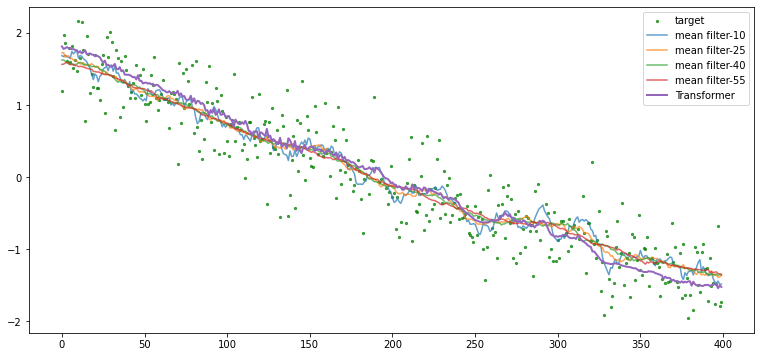

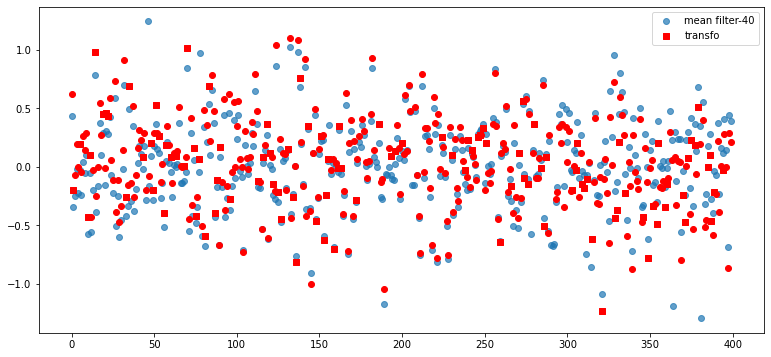

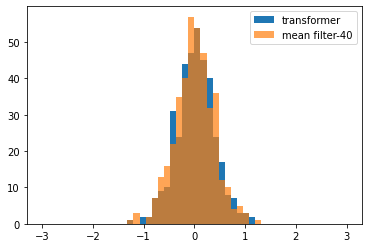

In [1560]:
plt.figure(figsize=(13,6))
plt.scatter(range(len(target)), target, label='target', color='green', alpha=0.7, s=5)
#plt.plot(pred, label='Transformer', color='red', alpha=0.7)
for w in pred_mean:
    plt.plot(pred_mean[w][i], label=f'mean filter-{w}', alpha=0.7)

plt.plot(pred, label='Transformer', lw=2)
plt.legend()
plt.show()

plt.figure(figsize=(13,6))
for w in [40]:
    plt.scatter(range(len(pred_mean[w][i])), 
                pred_mean[w][i]-Y[i,:,j].detach().numpy(), label=f'mean filter-{w}', alpha=0.7)
#     plt.scatter(range(len(res)), res, color='blue')

plt.scatter(range(len(res)), res, color='red')

plt.scatter(range(len(res)), res_m, marker="s", color='red', label='transfo')
#     plt.scatter(range(len(res)), res_m, marker="s", color='blue')
plt.legend()
plt.show()


plt.hist(res.numpy(), 50, range=(-3,3), label='transformer')
plt.hist(res_mean[w][i], 50, range=(-3,3), label=f'mean filter-{w}', alpha=0.7)
plt.legend()
plt.show()
pass

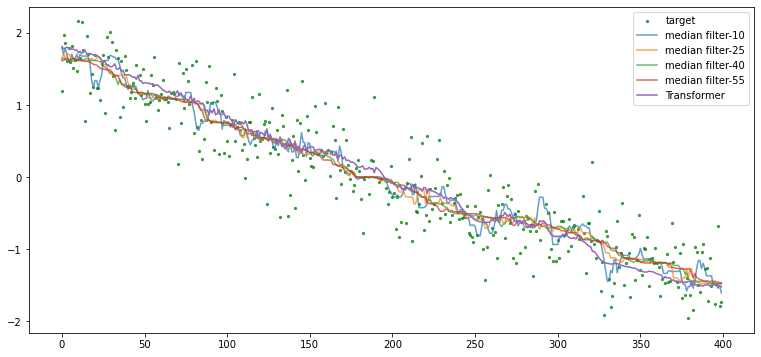

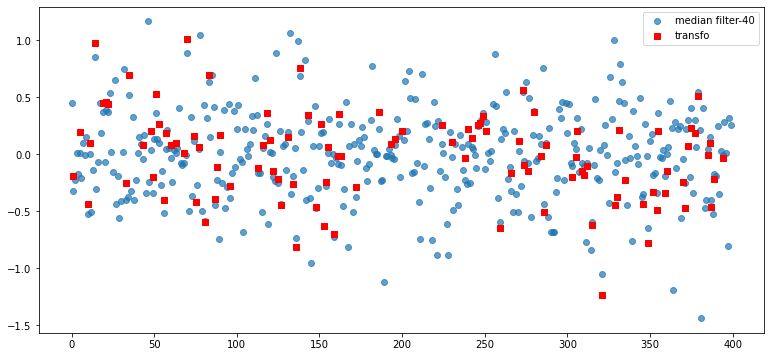

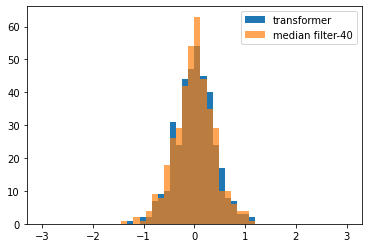

In [1558]:
plt.figure(figsize=(13,6))
plt.scatter(range(len(target)), target, label='target', color='green', alpha=0.7, s=5)
#plt.plot(pred, label='Transformer', color='red', alpha=0.7)
for w in pred_median:
    plt.plot(pred_median[w][i], label=f'median filter-{w}', alpha=0.7)

plt.plot(pred, label='Transformer')
plt.legend()
plt.show()

plt.figure(figsize=(13,6))
for w in [40]:
    plt.scatter(range(len(pred_median[w][i])), 
                pred_median[w][i]-Y[i,:,j].detach().numpy(), label=f'median filter-{w}', alpha=0.7)
#     plt.scatter(range(len(res)), res, color='blue')


plt.scatter(range(len(res)), res_m, marker="s", color='red', label='transfo')
#     plt.scatter(range(len(res)), res_m, marker="s", color='blue')
plt.legend()
plt.show()


plt.hist(res.numpy(), 50, range=(-3,3), label='transformer')
plt.hist(res_median[w][i], 50, range=(-3,3), label=f'median filter-{w}', alpha=0.7)
plt.legend()
plt.show()
pass

In [1525]:
pred_mean[w].shape

(128, 400)

### Visualise attention